# Visão geral mapeamento SIGTAP - OMOP

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")

In [2]:
#Tabela source, baixada do Dolthub com termos mapeados até então
#Arquivo necessário: 'ohdsi-brasil_sigtap_omop_main_tb_procedimento_dolt.csv'

df_src = pd.read_csv("ohdsi-brasil_sigtap_omop_main_tb_procedimento_dolt.csv")
df_src.columns

Index(['sourceCode', 'sourceName', 'sourceFrequency',
       'sourceAutoAssignedConceptIds', 'ADD_INFO:NOME_PROCEDIMENTO',
       'matchScore', 'mappingStatus', 'equivalence', 'statusSetBy',
       'statusSetOn', 'conceptId', 'conceptName', 'domainId', 'mappingType',
       'comment', 'createdBy', 'createdOn', 'assignedReviewer'],
      dtype='object')

In [3]:
#Tabela exportada pelo Usagi. Abrir o arquivo anterior no Usagi e exportar apenas com termos aprovados
#Dessa forma resgatamos a informação de origem do vocabulário para termo mapeado (OMOP)
#Arquivo necessário: 'tabela_approved.csv'

df_exp = pd.read_csv("tabela_approved.csv")
df_exp.columns

Index(['sourceCode', 'sourceName', 'sourceFrequency',
       'sourceAutoAssignedConceptIds', 'ADD_INFO:NOME_PROCEDIMENTO',
       'matchScore', 'targetConceptId', 'targetConceptName',
       'targetVocabularyId', 'targetDomainId', 'targetStandardConcept',
       'targetChildCount', 'targetParentCount', 'targetConceptClassId',
       'targetConceptCode', 'targetValidStartDate', 'targetValidEndDate',
       'targetInvalidReason'],
      dtype='object')

In [4]:
# Tamanhos diferentes das tabelas!
len(df_src), len(df_exp)

(3822, 3709)

Observation       3
Device            3
Condition         4
Procedure      1143
Drug           2556
Name: targetDomainId, dtype: int64

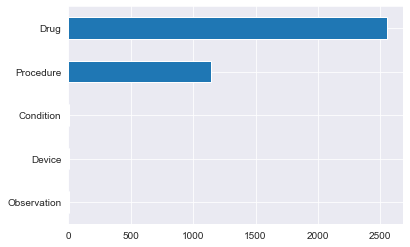

In [5]:
#Conferindo os domínios dos termos mapeados da tabela "approved" 

df_exp["targetDomainId"].value_counts(ascending = True).plot(kind = "barh")
df_exp["targetDomainId"].value_counts(ascending = True)

In [6]:
#Contribuições segundo a tabela "source" (sanity check com https://www.dolthub.com/repositories/ohdsi-brasil/sigtap_omop/query/main?active=Views&q=SELECT+*+FROM+%60contribui%C3%A7%C3%B5es+por+participante%60) 

#df_src["statusSetBy"].value_counts(ascending = True).plot(kind = "barh")
df_src["statusSetBy"].value_counts()

sigtap_omop_admin              638
carlosalcampos                 518
davidfrancelino                350
prisnormando                   302
miemukai                       189
fredjorge                      180
andersonfedel                  176
carlalima                      149
laurojeferson                  123
deborah                        120
neurilene                      104
joaogabrielzc                  102
dilvan                         100
greici                          98
vivianfurlans2@gmail.com        80
aleocidio                       62
juliobarbour                    54
mateuslfreitas                  51
Abrahaom                        50
silvaniateixeira                50
andreeluizpinto@gmail.com       50
lemiranda90                     49
robertaeduarda06@gmail.com      49
clark.theisen@ebserh.gov.br     49
silvaregop@gmail.com            31
osmeire                         29
tynthia                         20
borges.lissa@gmail.com          20
gbsander            

In [7]:
#Separando datasets po domínio (Medicamentos , Procedimentos cirúrgicos)

df_expm = df_exp[df_exp["targetDomainId"] == "Drug"]
df_expc = df_exp[df_exp["targetDomainId"] == "Procedure"]
len(df_expm), len(df_expc)

(2556, 1143)

## Visão geral dos vocabulário utilizados

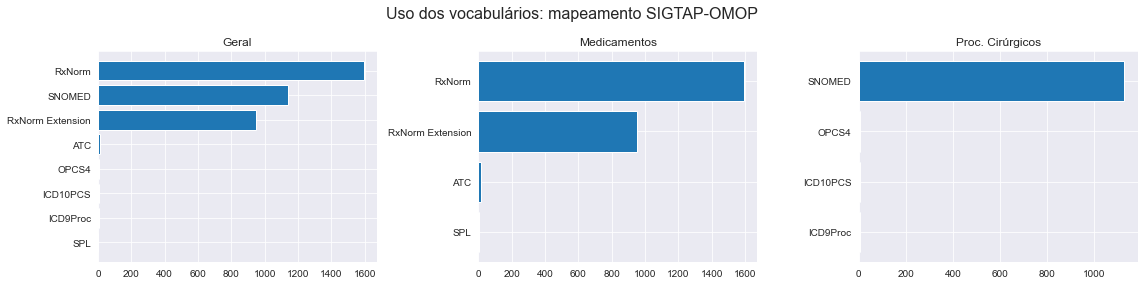

In [8]:
#Plot geral com vocabulários utilizados

data = df_exp["targetVocabularyId"].value_counts(ascending = True)
datam = df_expm["targetVocabularyId"].value_counts(ascending = True)
datac = df_expc["targetVocabularyId"].value_counts(ascending = True)

fig, axs = plt.subplots(1,3, figsize = (16,4))
plt.suptitle("Uso dos vocabulários: mapeamento SIGTAP-OMOP", fontsize = 16)


axs[0].set_title("Geral")
axs[0].barh(data.index, data)

axs[1].set_title("Medicamentos")
axs[1].barh(datam.index, datam)

axs[2].set_title("Proc. Cirúrgicos")
axs[2].barh(datac.index, datac)

plt.tight_layout()
plt.savefig("map.png")

## A partir daqui trabalharemos apenas com os termos relativos a MEDICAMENTOS

In [9]:
#Criando uma key para a associação SIGTAP -> OMOP realizada pelo usuário
df_expm["map_key"] = df_expm["ADD_INFO:NOME_PROCEDIMENTO"] + " -> " + df_expm["targetConceptName"] 

df_expm["map_key"].head()

C:\Users\ander\AppData\Local\Temp\ipykernel_11380\579506379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_expm["map_key"] = df_expm["ADD_INFO:NOME_PROCEDIMENTO"] + " -> " + df_expm["targetConceptName"]


1149    METILPREDNISOLONA 500 MG INJENTAVEL (POR AMPOL...
1150    METILPREDNISOLONA 500 MG INJENTAVEL (POR AMPOL...
1151    METILPREDNISOLONA 500 MG INJENTAVEL (POR AMPOL...
1152    METILPREDNISOLONA 500 MG INJENTAVEL (POR AMPOL...
1153    METILPREDNISOLONA 500 MG INJENTAVEL (POR AMPOL...
Name: map_key, dtype: object

In [10]:
#Series temporária com contagens das diferentes associações
map_series = df_expm["map_key"].value_counts()
map_series

PANCREATINA 10.000 UI (POR CAPSULA) -> Pancreatin 10000 UNT Oral Capsule                                         21
ÁCIDO NICOTÍNICO 250MG (POR COMPRIMIDO DE LIBERAÇÃO PROLONGADA) -> niacin 250 MG Extended Release Oral Tablet    17
ALFATALIGLICERASE 200 U INJETÁVEL (POR FRASCO AMPOLA) -> taliglucerase alfa 200 UNT Injection                    15
DESMOPRESSINA 0,1 MG (POR COMPRIMIDO) -> desmopressin acetate 0.1 MG Oral Tablet                                 15
PRAMIPEXOL 1 MG (POR COMPRIMIDO) -> pramipexole dihydrochloride 1 MG Oral Tablet                                 13
                                                                                                                 ..
ALFAEPOETINA 1.000 UI INJETAVEL (POR FRASCO-AMPOLA) -> epoetin alfa 10000 UNT/ML Injectable Solution              1
ALFAEPOETINA 1.000 UI INJETAVEL (POR FRASCO-AMPOLA) -> 0.5 ML Epoetin Alfa 2000 UNT/ML Injection                  1
ALFAEPOETINA 1.000 UI INJETAVEL (POR FRASCO-AMPOLA) -> epoetin alfa Inje

In [11]:
#Selecionando as ocorrências com 3 ou mais concordâncias de mapeamento
consenso = 3

map_cons = map_series[map_series >= consenso]
map_cons

PANCREATINA 10.000 UI (POR CAPSULA) -> Pancreatin 10000 UNT Oral Capsule                                         21
ÁCIDO NICOTÍNICO 250MG (POR COMPRIMIDO DE LIBERAÇÃO PROLONGADA) -> niacin 250 MG Extended Release Oral Tablet    17
ALFATALIGLICERASE 200 U INJETÁVEL (POR FRASCO AMPOLA) -> taliglucerase alfa 200 UNT Injection                    15
DESMOPRESSINA 0,1 MG (POR COMPRIMIDO) -> desmopressin acetate 0.1 MG Oral Tablet                                 15
PRAMIPEXOL 1 MG (POR COMPRIMIDO) -> pramipexole dihydrochloride 1 MG Oral Tablet                                 13
                                                                                                                 ..
LEUPRORRELINA 3,75 MG INJETAVEL (POR FRASCO-AMPOLA) -> Leuprolide 3.75 MG Injectable Solution                     3
DONEPEZILA 10 MG (POR COMPRIMIDO) -> donepezil 10 MG Oral Tablet by DE                                            3
IDURSULFASE ALFA 2 MG/ML SOLUÇÃO INJETÁVEL (FRASCO DE 3 ML) -> idursulfa

In [12]:
#Criando um DataFrame apenas com os MAPEAMENTOS que entraram em regra de consenso

df_cons = df_expm.set_index(df_expm["map_key"]).loc[map_cons.index]
df_cons

,sourceCode,sourceName,sourceFrequency,sourceAutoAssignedConceptIds,ADD_INFO:NOME_PROCEDIMENTO,matchScore,targetConceptId,targetConceptName,targetVocabularyId,targetDomainId,targetStandardConcept,targetChildCount,targetParentCount,targetConceptClassId,targetConceptCode,targetValidStartDate,targetValidEndDate,targetInvalidReason,map_key
map_key,,,,,,,,,,,,,,,,,,,
PANCREATINA 10.000 UI (POR CAPSULA) -> Pancreatin 10000 UNT Oral Capsule,604580010,Pancreatine 10000 IU (by capsule),-1,NaN,PANCREATINA 10.000 UI (POR CAPSULA),0.50,40825464,Pancreatin 10000 UNT Oral Capsule,RxNorm Extension,Drug,S,64,2,Clinical Drug,OMOP2023426,20170824,20991231,NaN,PANCREATINA 10.000 UI (POR CAPSULA) -> Pancrea...
PANCREATINA 10.000 UI (POR CAPSULA) -> Pancreatin 10000 UNT Oral Capsule,604580010,Pancreatine 10000 IU (by capsule),-1,NaN,PANCREATINA 10.000 UI (POR CAPSULA),0.50,40825464,Pancreatin 10000 UNT Oral Capsule,RxNorm Extension,Drug,S,64,2,Clinical Drug,OMOP2023426,20170824,20991231,NaN,PANCREATINA 10.000 UI (POR CAPSULA) -> Pancrea...
PANCREATINA 10.000 UI (POR CAPSULA) -> Pancreatin 10000 UNT Oral Capsule,604580010,Pancreatine 10000 IU (by capsule),-1,NaN,PANCREATINA 10.000 UI (POR CAPSULA),0.50,40825464,Pancreatin 10000 UNT Oral Capsule,RxNorm Extension,Drug,S,64,2,Clinical Drug,OMOP2023426,20170824,20991231,NaN,PANCREATINA 10.000 UI (POR CAPSULA) -> Pancrea...
PANCREATINA 10.000 UI (POR CAPSULA) -> Pancreatin 10000 UNT Oral Capsule,604580010,Pancreatine 10000 IU (by capsule),-1,NaN,PANCREATINA 10.000 UI (POR CAPSULA),0.50,40825464,Pancreatin 10000 UNT Oral Capsule,RxNorm Extension,Drug,S,64,2,Clinical Drug,OMOP2023426,20170824,20991231,NaN,PANCREATINA 10.000 UI (POR CAPSULA) -> Pancrea...
PANCREATINA 10.000 UI (POR CAPSULA) -> Pancreatin 10000 UNT Oral Capsule,604580010,Pancreatine 10000 IU (by capsule),-1,NaN,PANCREATINA 10.000 UI (POR CAPSULA),0.50,40825464,Pancreatin 10000 UNT Oral Capsule,RxNorm Extension,Drug,S,64,2,Clinical Drug,OMOP2023426,20170824,20991231,NaN,PANCREATINA 10.000 UI (POR CAPSULA) -> Pancrea...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"LEUPRORRELINA 3,75 MG INJETAVEL (POR FRASCO-AMPOLA) -> Leuprolide 3.75 MG Injection",604110030,Leuprorelin 3.75 mg injectable (by vial),-1,NaN,"LEUPRORRELINA 3,75 MG INJETAVEL (POR FRASCO-AM...",0.56,21080971,Leuprolide 3.75 MG Injection,RxNorm Extension,Drug,S,37,2,Clinical Drug,OMOP346622,20170824,20991231,NaN,"LEUPRORRELINA 3,75 MG INJETAVEL (POR FRASCO-AM..."
"LEUPRORRELINA 3,75 MG INJETAVEL (POR FRASCO-AMPOLA) -> Leuprolide 3.75 MG Injection",604110030,Leuprorelin 3.75 mg injectable (by vial),-1,NaN,"LEUPRORRELINA 3,75 MG INJETAVEL (POR FRASCO-AM...",0.56,21080971,Leuprolide 3.75 MG Injection,RxNorm Extension,Drug,S,37,2,Clinical Drug,OMOP346622,20170824,20991231,NaN,"LEUPRORRELINA 3,75 MG INJETAVEL (POR FRASCO-AM..."
"LEUPRORRELINA 11,25 MG INJETAVEL (POR FRASCO-AMPOLA) -> Leuprolide 11.3 MG Injection",604110049,Leuprorelin 11.25 mg injectable (by vial),-1,NaN,"LEUPRORRELINA 11,25 MG INJETAVEL (POR FRASCO-A...",0.54,21139863,Leuprolide 11.3 MG Injection,RxNorm Extension,Drug,S,22,2,Clinical Drug,OMOP346655,20170824,20991231,NaN,"LEUPRORRELINA 11,25 MG INJETAVEL (POR FRASCO-A..."


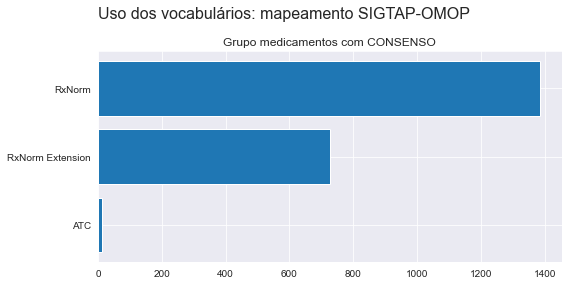

In [13]:
# Plot vocabulários utilizados
#df_cons["targetVocabularyId"].value_counts(ascending = True).plot(kind = "barh")

data = df_cons["targetVocabularyId"].value_counts(ascending = True)


fig, axs = plt.subplots(1, figsize = (8,4))
plt.suptitle("Uso dos vocabulários: mapeamento SIGTAP-OMOP", fontsize = 16)

axs.set_title("Grupo medicamentos com CONSENSO")
axs.barh(data.index, data)

plt.tight_layout()
plt.savefig("consenso.png")

In [19]:
# #Analisando os casos onde não foram utilizados os vocabulários RxNorm 
# df_cons[df_cons["targetVocabularyId"] == "ATC"]

In [21]:
#Atenção: aparentemente termos SIGTAP mapeados para mais de um termo OMOP com consenso!
len(df_cons), len(df_cons.drop_duplicates(subset = ["ADD_INFO:NOME_PROCEDIMENTO"])), len(df_cons[~df_cons.index.duplicated(keep='first')])

(2123, 334, 390)

In [22]:
df_cons_un = df_cons[~df_cons.index.duplicated(keep='first')]
df_cons_un

,sourceCode,sourceName,sourceFrequency,sourceAutoAssignedConceptIds,ADD_INFO:NOME_PROCEDIMENTO,matchScore,targetConceptId,targetConceptName,targetVocabularyId,targetDomainId,targetStandardConcept,targetChildCount,targetParentCount,targetConceptClassId,targetConceptCode,targetValidStartDate,targetValidEndDate,targetInvalidReason,map_key
map_key,,,,,,,,,,,,,,,,,,,
PANCREATINA 10.000 UI (POR CAPSULA) -> Pancreatin 10000 UNT Oral Capsule,604580010,Pancreatine 10000 IU (by capsule),-1,NaN,PANCREATINA 10.000 UI (POR CAPSULA),0.50,40825464,Pancreatin 10000 UNT Oral Capsule,RxNorm Extension,Drug,S,64,2,Clinical Drug,OMOP2023426,20170824,20991231,NaN,PANCREATINA 10.000 UI (POR CAPSULA) -> Pancrea...
ÁCIDO NICOTÍNICO 250MG (POR COMPRIMIDO DE LIBERAÇÃO PROLONGADA) -> niacin 250 MG Extended Release Oral Tablet,604270097,Nicotinic acid 250 mg (by extended release tab...,-1,NaN,ÁCIDO NICOTÍNICO 250MG (POR COMPRIMIDO DE LIBE...,0.53,1517987,niacin 250 MG Extended Release Oral Tablet,RxNorm,Drug,S,0,4,Clinical Drug,311955,19700101,20991231,NaN,ÁCIDO NICOTÍNICO 250MG (POR COMPRIMIDO DE LIBE...
ALFATALIGLICERASE 200 U INJETÁVEL (POR FRASCO AMPOLA) -> taliglucerase alfa 200 UNT Injection,604240023,Taliglucerase Alfa 200 U injectable (by vial),-1,NaN,ALFATALIGLICERASE 200 U INJETÁVEL (POR FRASCO ...,0.34,42800248,taliglucerase alfa 200 UNT Injection,RxNorm,Drug,S,0,3,Clinical Drug,1292879,20120604,20991231,NaN,ALFATALIGLICERASE 200 U INJETÁVEL (POR FRASCO ...
"DESMOPRESSINA 0,1 MG (POR COMPRIMIDO) -> desmopressin acetate 0.1 MG Oral Tablet",604100027,Desmopressin 0.1 mg (by tablet),-1,NaN,"DESMOPRESSINA 0,1 MG (POR COMPRIMIDO)",0.75,1517147,desmopressin acetate 0.1 MG Oral Tablet,RxNorm,Drug,S,108,4,Clinical Drug,849515,20090531,20991231,NaN,"DESMOPRESSINA 0,1 MG (POR COMPRIMIDO) -> desmo..."
PRAMIPEXOL 1 MG (POR COMPRIMIDO) -> pramipexole dihydrochloride 1 MG Oral Tablet,604030061,Pramipexol 1 mg (by tablet),-1,NaN,PRAMIPEXOL 1 MG (POR COMPRIMIDO),0.61,40165177,pramipexole dihydrochloride 1 MG Oral Tablet,RxNorm,Drug,S,227,4,Clinical Drug,859052,20090906,20991231,NaN,PRAMIPEXOL 1 MG (POR COMPRIMIDO) -> pramipexol...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"LEUPRORRELINA 3,75 MG INJETAVEL (POR FRASCO-AMPOLA) -> Leuprolide 3.75 MG Injectable Solution",604110030,Leuprorelin 3.75 mg injectable (by vial),-1,NaN,"LEUPRORRELINA 3,75 MG INJETAVEL (POR FRASCO-AM...",0.56,41022332,Leuprolide 3.75 MG Injectable Solution,RxNorm Extension,Drug,S,24,2,Clinical Drug,OMOP2220294,20170824,20991231,NaN,"LEUPRORRELINA 3,75 MG INJETAVEL (POR FRASCO-AM..."
DONEPEZILA 10 MG (POR COMPRIMIDO) -> donepezil 10 MG Oral Tablet by DE,604130023,Donepezila 10 mg (by tablet),-1,NaN,DONEPEZILA 10 MG (POR COMPRIMIDO),0.63,21128624,donepezil 10 MG Oral Tablet by DE,RxNorm Extension,Drug,S,0,1,Marketed Product,OMOP314591,20170824,20991231,NaN,DONEPEZILA 10 MG (POR COMPRIMIDO) -> donepezil...
IDURSULFASE ALFA 2 MG/ML SOLUÇÃO INJETÁVEL (FRASCO DE 3 ML) -> idursulfase 2 MG/ML Injectable Solution,604240074,Idursulfase Alfa 2 mg/ml injectable solution (...,-1,NaN,IDURSULFASE ALFA 2 MG/ML SOLUÇÃO INJETÁVEL (FR...,0.68,41022599,idursulfase 2 MG/ML Injectable Solution,RxNorm Extension,Drug,S,14,2,Clinical Drug,OMOP2220561,20170824,20991231,NaN,IDURSULFASE ALFA 2 MG/ML SOLUÇÃO INJETÁVEL (FR...


In [39]:
#Obtendo termos com dois mapeamentos
print("Número de termo com mais de um mapeamento:", len(df_cons_un[df_cons_un.duplicated(subset = 'ADD_INFO:NOME_PROCEDIMENTO')]))
print("")
df_cons_un[df_cons_un.duplicated(subset = "ADD_INFO:NOME_PROCEDIMENTO")].head()

Número de termo com mais de um mapeamento: 56



,sourceCode,sourceName,sourceFrequency,sourceAutoAssignedConceptIds,ADD_INFO:NOME_PROCEDIMENTO,matchScore,targetConceptId,targetConceptName,targetVocabularyId,targetDomainId,targetStandardConcept,targetChildCount,targetParentCount,targetConceptClassId,targetConceptCode,targetValidStartDate,targetValidEndDate,targetInvalidReason,map_key
map_key,,,,,,,,,,,,,,,,,,,
TRIENTINA 250 MG (POR CÁPSULA) -> Trientine 250 MG Oral Capsule Box of 100,604630077,Trientine 250 mg (by capsule),-1,NaN,TRIENTINA 250 MG (POR CÁPSULA),0.66,40753391,Trientine 250 MG Oral Capsule Box of 100,RxNorm Extension,Drug,S,0,1,Clinical Drug Box,OMOP4704331,20180604,20991231,NaN,TRIENTINA 250 MG (POR CÁPSULA) -> Trientine 25...
DONEPEZILA 5 MG (POR COMPRIMIDO) -> donepezil 5 MG Oral Capsule,604130015,Donepezila 5 mg (by tablet),-1,NaN,DONEPEZILA 5 MG (POR COMPRIMIDO),0.62,35869189,donepezil 5 MG Oral Capsule,RxNorm Extension,Drug,S,0,2,Clinical Drug,OMOP5025694,20201002,20991231,NaN,DONEPEZILA 5 MG (POR COMPRIMIDO) -> donepezil ...
BUDESONIDA 200 MCG (POR CAPSULA INALANTE) -> Budesonide 0.2 MG Inhalant Powder,604280068,Budesonide 200 mcg (by inhalant capsule),-1,NaN,BUDESONIDA 200 MCG (POR CAPSULA INALANTE),0.58,36406674,Budesonide 0.2 MG Inhalant Powder,RxNorm Extension,Drug,S,3,0,Clinical Drug,OMOP3098716,20170802,20991231,NaN,BUDESONIDA 200 MCG (POR CAPSULA INALANTE) -> B...
ABATACEPTE 250 MG INJETÁVEL (POR FRASCO AMPOLA). -> abatacept 250 MG Injection,604320124,Abatacept 250 mg injectable (by vial).,-1,NaN,ABATACEPTE 250 MG INJETÁVEL (POR FRASCO AMPOLA).,0.60,19123382,abatacept 250 MG Injection,RxNorm,Drug,S,5,3,Clinical Drug,616015,20060402,20991231,NaN,ABATACEPTE 250 MG INJETÁVEL (POR FRASCO AMPOLA...
INFLIXIMABE 10 MG/ML INJETAVEL (POR FRASCO-AMPOLA COM 10 ML) -> infliximab Injection,604380046,Infliximab 10 mg/ml injectable (by 10 ml vial),-1,NaN,INFLIXIMABE 10 MG/ML INJETAVEL (POR FRASCO-AMP...,0.67,46275593,infliximab Injection,RxNorm,Drug,S,12,8,Clinical Drug Form,1655941,20150908,20991231,NaN,INFLIXIMABE 10 MG/ML INJETAVEL (POR FRASCO-AMP...


In [32]:
#Exemplo de termo com mapeamento para 2 termos OMOP com consenso: TRIENTINA 250 MG (POR CÁPSULA)
df_cons[df_cons["ADD_INFO:NOME_PROCEDIMENTO"] == "TRIENTINA 250 MG (POR CÁPSULA)"]

,sourceCode,sourceName,sourceFrequency,sourceAutoAssignedConceptIds,ADD_INFO:NOME_PROCEDIMENTO,matchScore,targetConceptId,targetConceptName,targetVocabularyId,targetDomainId,targetStandardConcept,targetChildCount,targetParentCount,targetConceptClassId,targetConceptCode,targetValidStartDate,targetValidEndDate,targetInvalidReason,map_key
map_key,,,,,,,,,,,,,,,,,,,
TRIENTINA 250 MG (POR CÁPSULA) -> trientine hydrochloride 250 MG Oral Capsule,604630077,Trientine 250 mg (by capsule),-1,NaN,TRIENTINA 250 MG (POR CÁPSULA),0.66,19004991,trientine hydrochloride 250 MG Oral Capsule,RxNorm,Drug,S,5,4,Clinical Drug,313472,19700101,20991231,NaN,TRIENTINA 250 MG (POR CÁPSULA) -> trientine hy...
TRIENTINA 250 MG (POR CÁPSULA) -> trientine hydrochloride 250 MG Oral Capsule,604630077,Trientine 250 mg (by capsule),-1,NaN,TRIENTINA 250 MG (POR CÁPSULA),0.66,19004991,trientine hydrochloride 250 MG Oral Capsule,RxNorm,Drug,S,5,4,Clinical Drug,313472,19700101,20991231,NaN,TRIENTINA 250 MG (POR CÁPSULA) -> trientine hy...
TRIENTINA 250 MG (POR CÁPSULA) -> trientine hydrochloride 250 MG Oral Capsule,604630077,Trientine 250 mg (by capsule),-1,NaN,TRIENTINA 250 MG (POR CÁPSULA),0.66,19004991,trientine hydrochloride 250 MG Oral Capsule,RxNorm,Drug,S,5,4,Clinical Drug,313472,19700101,20991231,NaN,TRIENTINA 250 MG (POR CÁPSULA) -> trientine hy...
TRIENTINA 250 MG (POR CÁPSULA) -> trientine hydrochloride 250 MG Oral Capsule,604630077,Trientine 250 mg (by capsule),-1,NaN,TRIENTINA 250 MG (POR CÁPSULA),0.66,19004991,trientine hydrochloride 250 MG Oral Capsule,RxNorm,Drug,S,5,4,Clinical Drug,313472,19700101,20991231,NaN,TRIENTINA 250 MG (POR CÁPSULA) -> trientine hy...
TRIENTINA 250 MG (POR CÁPSULA) -> trientine hydrochloride 250 MG Oral Capsule,604630077,Trientine 250 mg (by capsule),-1,NaN,TRIENTINA 250 MG (POR CÁPSULA),0.66,19004991,trientine hydrochloride 250 MG Oral Capsule,RxNorm,Drug,S,5,4,Clinical Drug,313472,19700101,20991231,NaN,TRIENTINA 250 MG (POR CÁPSULA) -> trientine hy...
TRIENTINA 250 MG (POR CÁPSULA) -> trientine hydrochloride 250 MG Oral Capsule,604630077,Trientine 250 mg (by capsule),-1,NaN,TRIENTINA 250 MG (POR CÁPSULA),0.66,19004991,trientine hydrochloride 250 MG Oral Capsule,RxNorm,Drug,S,5,4,Clinical Drug,313472,19700101,20991231,NaN,TRIENTINA 250 MG (POR CÁPSULA) -> trientine hy...
TRIENTINA 250 MG (POR CÁPSULA) -> trientine hydrochloride 250 MG Oral Capsule,604630077,Trientine 250 mg (by capsule),-1,NaN,TRIENTINA 250 MG (POR CÁPSULA),0.66,19004991,trientine hydrochloride 250 MG Oral Capsule,RxNorm,Drug,S,5,4,Clinical Drug,313472,19700101,20991231,NaN,TRIENTINA 250 MG (POR CÁPSULA) -> trientine hy...
TRIENTINA 250 MG (POR CÁPSULA) -> trientine hydrochloride 250 MG Oral Capsule,604630077,Trientine 250 mg (by capsule),-1,NaN,TRIENTINA 250 MG (POR CÁPSULA),0.66,19004991,trientine hydrochloride 250 MG Oral Capsule,RxNorm,Drug,S,5,4,Clinical Drug,313472,19700101,20991231,NaN,TRIENTINA 250 MG (POR CÁPSULA) -> trientine hy...
TRIENTINA 250 MG (POR CÁPSULA) -> trientine hydrochloride 250 MG Oral Capsule,604630077,Trientine 250 mg (by capsule),-1,NaN,TRIENTINA 250 MG (POR CÁPSULA),0.66,19004991,trientine hydrochloride 250 MG Oral Capsule,RxNorm,Drug,S,5,4,Clinical Drug,313472,19700101,20991231,NaN,TRIENTINA 250 MG (POR CÁPSULA) -> trientine hy...
